## Basic classifier that uses Bidirectional Gated Recurrent Unit (bigru) to predict if the payload is an SQL injection

Let's import our stuff here


In [1]:
!pip3 install scikit-learn>=1.0.0
!pip3 install ktrain matplotlib tensorflow numpy
import matplotlib
import os
import numpy as np
%reload_ext autoreload
%autoreload 2
%matplotlib inline
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

Some more imports...We are using ktrain wrapper to simplify model operations and take advantage of some cool stuff like autofit

In [2]:
import ktrain
from ktrain import text

Here, we will classify payload to "malicious sqli" and "benign" . Data set is presented as a CSV file (i.e., download the file ```SQLiV3a_.csv```).  We will load the data using the ```texts_from_csv``` method, which assumes the label_columns are already one-hot-encoded in the spreadsheet. Since *val_filepath* is None, 10% of the data will automatically be used as a validation set.


In [7]:
DATA_PATH = 'trainlist_22k.csv'
NUM_WORDS = 50000
MAXLEN = 100
trn, val, preproc = text.texts_from_csv(DATA_PATH,
                      'payload',
                      label_columns = ["type"],
                      val_filepath=None, # if None, 10% of data will be used for validation
                      max_features=NUM_WORDS, maxlen=MAXLEN,
                      ngram_range=1,
                      preprocess_mode='distilbert')

detected encoding: UTF-8-SIG (if wrong, set manually)
['benign', 'sqli', 'xss']
       benign  sqli  xss
12648     0.0   0.0  1.0
16020     0.0   1.0  0.0
14329     1.0   0.0  0.0
12707     0.0   1.0  0.0
9413      1.0   0.0  0.0
['benign', 'sqli', 'xss']
       benign  sqli  xss
8672      0.0   1.0  0.0
507       0.0   1.0  0.0
5412      0.0   1.0  0.0
19730     1.0   0.0  0.0
8444      0.0   1.0  0.0
preprocessing train...
language: en
train sequence lengths:
	mean : 9
	95percentile : 40
	99percentile : 80


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 10
	95percentile : 41
	99percentile : 78


Load the learner instance that uses ```bigru``` model 

In [8]:
model = text.text_classifier('distilbert', (trn), 
                             preproc=preproc)
learner = ktrain.get_learner(model, train_data=(trn), val_data=(val))

Is Multi-Label? False
maxlen is 100


Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

done.


Now let's find the optimal learning rate for this model

In [ ]:
text.print_text_classifiers()

simulating training for different learning rates... this may take a few moments...
Epoch 1/2
631/631 [==============================] - 1526s 2s/step - loss: 0.4781 - accuracy: 0.7985
Epoch 2/2
631/631 [==============================] - 930s 1s/step - loss: 52.9197 - accuracy: 0.3729


done.
Visually inspect loss plot and select learning rate associated with falling loss


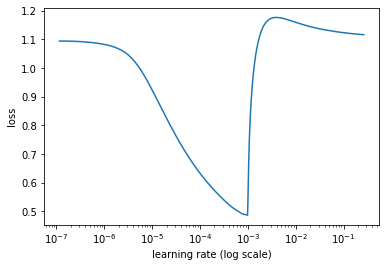

In [10]:
learner.lr_find(show_plot=True, max_epochs=2)

Train the model using the optimal learning rate ( adjust argument as needed accorfing to the graph)

In [ ]:
learner.freeze(104)

In [ ]:
learner.autofit(0.001)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Epoch 1/1024
632/632 [==============================] - 1572s 2s/step - loss: 0.9022 - accuracy: 0.5022 - val_loss: 1.0861 - val_accuracy: 0.3791
Epoch 2/1024
632/632 [==============================] - 1555s 2s/step - loss: 1.0774 - accuracy: 0.3749 - val_loss: 1.0789 - val_accuracy: 0.3719
Epoch 3/1024
 24/632 [>.............................] - ETA: 23:57 - loss: 1.0688 - accuracy: 0.3945

Now let's evaluate the the ```validation data set```

In [ ]:
learner.evaluate()

Here is what our model looks like. It has a number of layers that comprise this ```GRU```

In [9]:
learner.print_layers()


0 (trainable=True) : <transformers.models.distilbert.modeling_tf_distilbert.TFDistilBertMainLayer object at 0x7f8a6d6ee9d0>
1 (trainable=True) : <keras.layers.core.dense.Dense object at 0x7f8a6c10ebb0>
2 (trainable=True) : <keras.layers.core.dense.Dense object at 0x7f8a6c10eeb0>
3 (trainable=True) : <keras.layers.core.dropout.Dropout object at 0x7f8a6d4c01c0>


It's time for some fun! First, get a predictor instance that uses our pre-trained model

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)
predictor.save('detector_model_bert')
print('MODEL SAVED')

Let's see if it can catch an SQLi or XSS payload

In [ ]:
import pickle
from tensorflow.keras.models import load_model
# loading preprocess and model file
features = pickle.load(open('detector_model_bert/tf_model.preproc',
                            'rb'))
new_model = load_model('detector_model_bert/tf_model.h5')
labels = ['benign', 'sqli', 'xss']

In [ ]:
text = '<applet onkeydown="alert(1)" contenteditable>test</applet>'
preproc_text = features.preprocess([text])
result = new_model.predict(preproc_text)
print(result)
label = labels[result[0].argmax(axis=0)]
score = ('{:.2f}'.format(round(np.max(result[0]), 2)*100))
print('LABEL :', label, 'SCORE :', score)